In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as xrio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from shapely.geometry import shape
from raster_tools import surface, Raster, zonal
import cartopy.crs as ccrs
import numpy as np

In [2]:
lakes_gdf = gpd.read_file("lakes.geojson")

In [3]:
lakes_gdf

,id,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,ice_thickness,slope,geometry
0,0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,3919,0.086016,POINT (1296999.561 33963.129)
1,1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,3303,0.114682,POINT (1250803.318 -323479.733)
2,2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),3474,0.029392,POINT (1203517.434 -836466.407)
3,3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),2344,0.227904,POINT (706469.226 -1687214.515)
4,4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),3729,0.057291,POINT (1218054.666 -682702.029)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),3474,0.095858,POINT (1470914.122 -423028.361)
375,375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),3513,0.056701,POINT (1709145.571 -326593.471)
376,376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",1818,0.229883,POINT (2255000.417 -935896.682)
377,377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",1549,0.525441,POINT (2231263.202 -971570.334)


In [4]:
# Summary statistics for slope
print("Slope statistics for lakes:")
print(lakes_gdf['slope'].describe())

Slope statistics for lakes:
count    374.000000
mean       0.168172
std        0.225140
min        0.000852
25%        0.043810
50%        0.096491
75%        0.206799
max        2.159162
Name: slope, dtype: float64


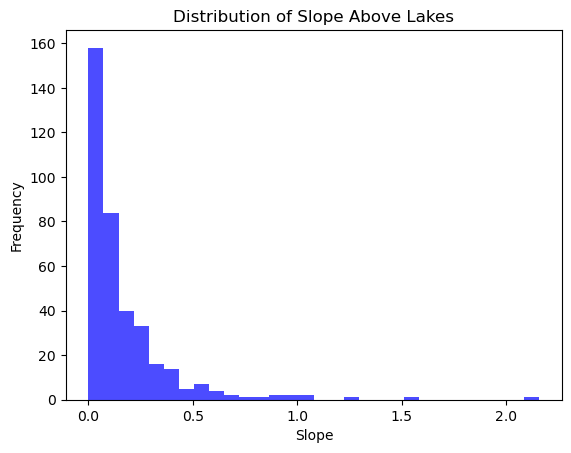

In [5]:
import matplotlib.pyplot as plt

# Histogram of slope values
plt.hist(lakes_gdf['slope'], bins=30, alpha=0.7, color='blue')
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Distribution of Slope Above Lakes")
plt.show()


In [6]:
# Flattest lakes (lowest slope values)
flattest_lakes = lakes_gdf.nsmallest(10, 'slope')
print("Flattest lakes:")
print(flattest_lakes[['Name', 'slope', 'ice_thickness']])


Flattest lakes:
           Name     slope  ice_thickness
185       LVS-3  0.000852           3680
368     R05Ea_5  0.003169           3554
174      WLK-34  0.004687           3164
56      SPRI-64  0.005655           3617
21   SPRI-25/76  0.005947           2809
182      WLK-42  0.006206           2721
304        EAP4  0.008170           3144
324       Kamb7  0.008317           2313
19      SPRI-23  0.010660           3019
161      WLK-18  0.010688           3320


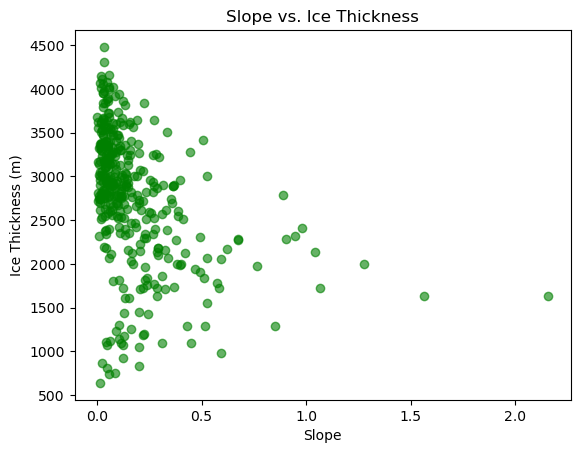

Correlation between slope and ice thickness: -0.383


In [7]:
# Scatter plot of slope vs ice thickness
plt.scatter(lakes_gdf['slope'], lakes_gdf['ice_thickness'], alpha=0.6, color='green')
plt.xlabel("Slope")
plt.ylabel("Ice Thickness (m)")
plt.title("Slope vs. Ice Thickness")
plt.show()

# Correlation
correlation = lakes_gdf['slope'].corr(lakes_gdf['ice_thickness'])
print(f"Correlation between slope and ice thickness: {correlation:.3f}")


In [8]:
# Lakes with high ice thickness but low slope
extreme_cases = lakes_gdf[(lakes_gdf['slope'] < 0.05) & (lakes_gdf['ice_thickness'] > lakes_gdf['ice_thickness'].mean())]
print("Lakes with high ice thickness but flat slopes:")
print(extreme_cases[['Name', 'slope', 'ice_thickness']])


Lakes with high ice thickness but flat slopes:
               Name     slope  ice_thickness
2            SPRI-3  0.029392           3474
5    Concordia Lake  0.011508           4069
9           SPRI-10  0.041788           3247
10    SPRI-11/ITL-7  0.038225           3105
11          SPRI-12  0.041939           3155
..              ...       ...            ...
369         R06Wa_4  0.049820           3862
370         R07Ea_9  0.028880           3654
371         R07Ta_1  0.033698           3644
372       R08Wa_0.1  0.020766           3619
373       R08Wa_0.2  0.025895           3671

[87 rows x 3 columns]


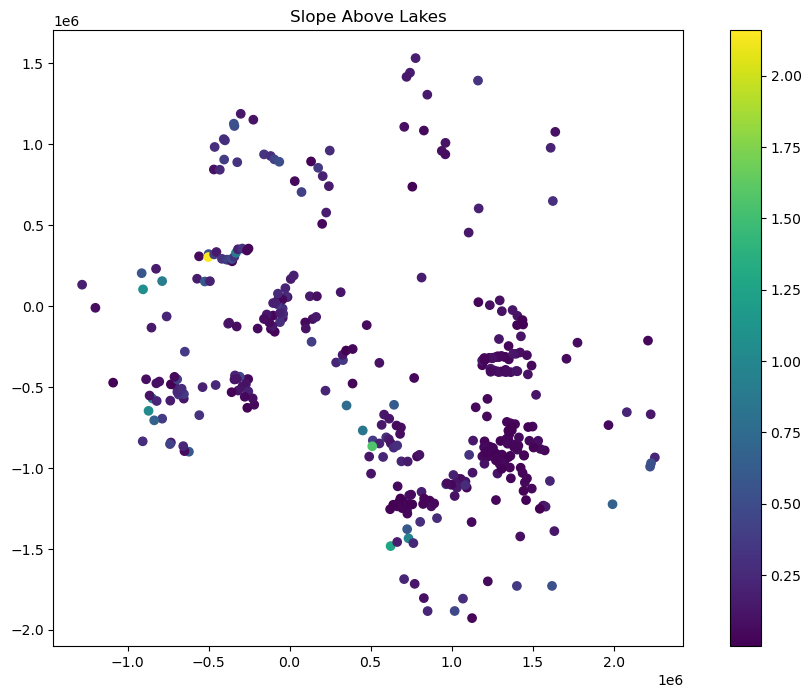

In [9]:
# Plot lakes by slope
lakes_gdf.plot(column='slope', cmap='viridis', legend=True, figsize=(12, 8))
plt.title("Slope Above Lakes")
plt.show()


closer eval of slope and lakes

In [10]:
from libpysal.weights import Queen

# Define spatial weights matrix based on contiguity
weights = Queen.from_dataframe(lakes_gdf)
weights.transform = 'r'  # Row standardize the weights


ImportError: cannot import name 'inf' from 'scipy' (c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\scipy\__init__.py)

In [ ]:
from esda.moran import Moran

# Compute Moran's I
moran = Moran(lakes_gdf['slope'], weights)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


In [ ]:
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# Compute Local Moran's I
local_moran = Moran_Local(lakes_gdf['slope'], weights)

# Add Local Moran's results to the GeoDataFrame
lakes_gdf['moran_i'] = local_moran.Is
lakes_gdf['p_sim'] = local_moran.p_sim

# Plot clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lakes_gdf.plot(column='moran_i', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I (Slope Clusters)")
plt.show()


In [ ]:
from esda.getisord import G

# Compute Getis-Ord Gi*
getis_ord = G(lakes_gdf['slope'], weights)

# Add results to GeoDataFrame
lakes_gdf['getis_g'] = getis_ord.Zs

# Plot hotspots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lakes_gdf.plot(column='getis_g', cmap='bwr', legend=True, ax=ax)
plt.title("Getis-Ord Gi* Hotspots (Slope)")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Create binary presence variable (1 for lake, 0 for non-lake regions)
lakes_gdf['lake_presence'] = 1  # All entries are lakes; modify if comparing with non-lake data

# Logistic regression
model = LogisticRegression()
X = np.array(lakes_gdf['slope']).reshape(-1, 1)
y = lakes_gdf['lake_presence']
model.fit(X, y)

print(f"Logistic Regression Coefficient for Slope: {model.coef_[0][0]}")


In [ ]:
# Plot lakes with slope clusters
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
lakes_gdf.plot(column='moran_i', cmap='coolwarm', legend=True, ax=ax, alpha=0.7)
lakes_gdf.plot(ax=ax, color='black', markersize=10, label='Lake Locations')
plt.legend()
plt.title("Spatial Clusters of Slope Around Lakes")
plt.show()


other

In [20]:
steep_lakes = lakes_gdf[lakes_gdf['slope'] > lakes_gdf['slope'].quantile(0.95)]
print(steep_lakes[['Name', 'slope']])

               Name     slope
39          SPRI-44  0.621841
114   Bindschadler5  0.947985
237  MacAyeal1/Mac1  0.594695
257        Academy3  2.159162
266       Academy12  0.890185
272   Bindschadler2  0.671975
273   Bindschadler3  1.041516
277          ByrdS2  1.563556
278          ByrdS3  0.850013
295          David1  1.275975
297          David3  0.982690
298          David4  0.591261
311     Foundation2  0.582792
314     InstituteE2  0.903954
315     InstituteW1  0.573157
316     InstituteW2  1.064880
333         Nimrod1  0.763418
352        Slessor5  0.527381
363         Wlikes2  0.672961


In [21]:
flat_lakes = lakes_gdf[lakes_gdf['slope'] < lakes_gdf['slope'].quantile(0.05)]
print(flat_lakes[['Name', 'slope', 'ice_thickness']])

                                     Name     slope  ice_thickness
5                          Concordia Lake  0.011508           4069
19                                SPRI-23  0.010660           3019
21                             SPRI-25/76  0.005947           2809
55                                SPRI-62  0.012113           2746
56                                SPRI-64  0.005655           3617
59                                SPRI-67  0.011084           2743
75                                  ITL 6  0.010818           2778
77                                  ITL 9  0.012843           3368
112                               C25SAE1  0.012658           3052
151                                 WLK-4  0.012867           2756
161                                WLK-18  0.010688           3320
174                                WLK-34  0.004687           3164
176                                WLK-36  0.012177           2962
182                                WLK-42  0.006206           

In [22]:
correlation = lakes_gdf['slope'].corr(lakes_gdf['ice_thickness'])
print(f"Correlation between slope and ice thickness: {correlation:.2f}")

Correlation between slope and ice thickness: -0.38


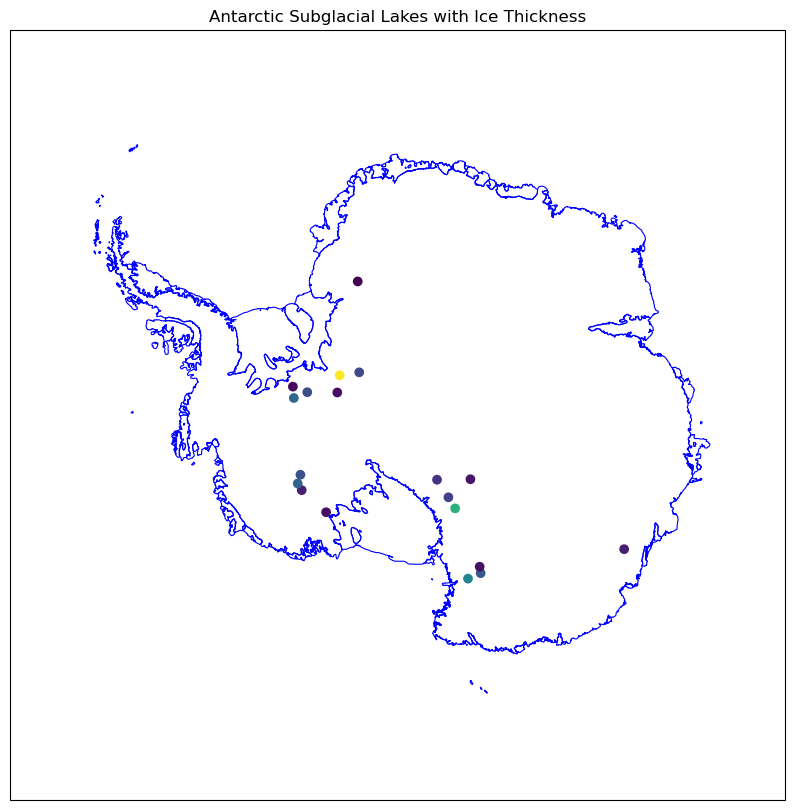

In [28]:
world = gpd.read_file('data\coastline\ADD_Coastline_low_res_polygon.shp')
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
steep_lakes.plot(ax=ax, column='slope', transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lakes with Ice Thickness")
plt.show()


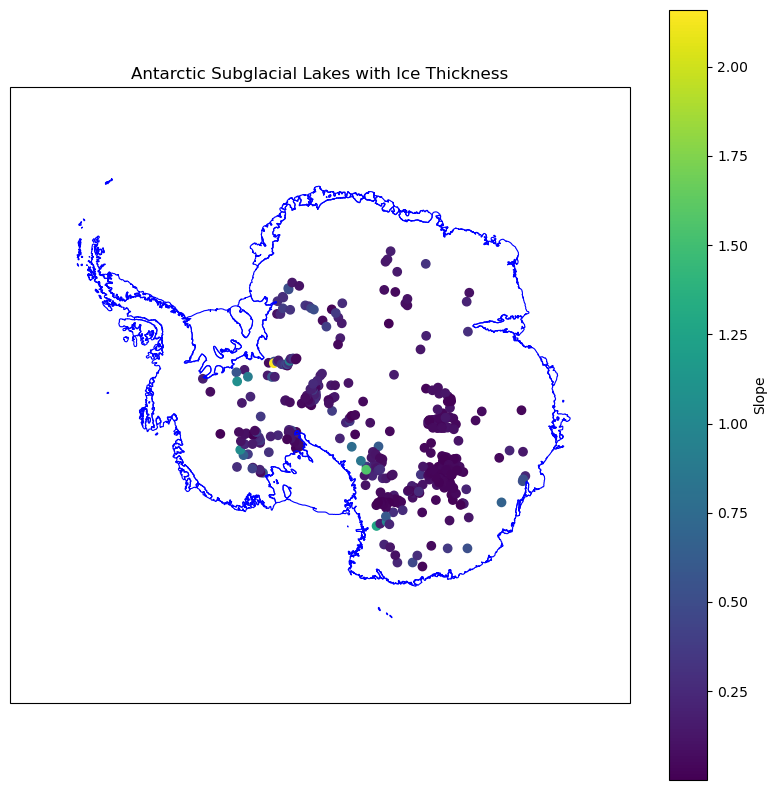

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
lakes_gdf.plot(ax=ax, cmap='viridis', column='slope', legend=True, 
               legend_kwds={'label': "Slope"}, transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lakes with Slope")
plt.show()